In [2]:
# usual imports
import matplotlib as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import tensorflow as tf
import visualkeras

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
# set seeds for repeatable conclusion
seed = 42
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# import the dataset
exoplanet_df = pd.read_csv('exoplanet_dataset.csv')

# first look
exoplanet_df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,8/16/2018,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,8/16/2018,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,8/16/2018,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,8/16/2018,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,8/16/2018,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [5]:
id_columns_to_remove = [
    'rowid',
    'kepid',
    'kepoi_name',
    'kepler_name',
    'koi_vet_stat',
    'koi_vet_date',
    'koi_pdisposition',
    'koi_score',
    'koi_fpflag_nt',
    'koi_fpflag_ss',
    'koi_fpflag_co',
    'koi_fpflag_ec',
    'koi_disp_prov',
    'koi_comment',
    'koi_limbdark_mod',
    'koi_trans_mod',
    'koi_datalink_dvr',
    'koi_datalink_dvs',
    'koi_sparprov',
    'koi_tce_delivname',
    'koi_fittype',
    'koi_parm_prov'
]

exoplanet_df.drop(id_columns_to_remove, axis=1, inplace=True)

<Axes: >

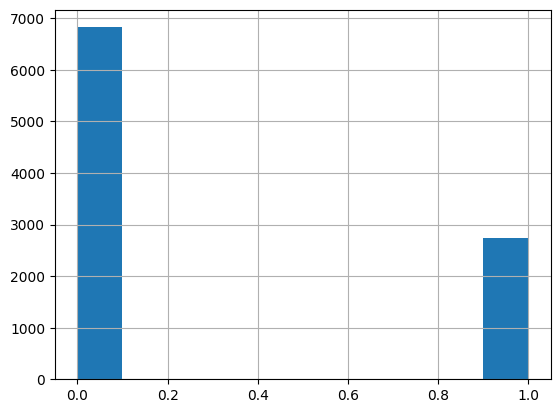

In [6]:
# find current values
exoplanet_df['koi_disposition'].unique()

# update dataframe column
exoplanet_df.replace('CONFIRMED', 1, inplace=True)
exoplanet_df.replace('CANDIDATE', 0, inplace=True)
exoplanet_df.replace('FALSE POSITIVE', 0, inplace=True)

# look at the distribution of the result
exoplanet_df['koi_disposition'].hist()

In [7]:

exoplanet_df = exoplanet_df.sample(frac=1).reset_index(drop=True)


for column in exoplanet_df.columns:
    if column != 'koi_disposition':
        exoplanet_df[column] = (exoplanet_df[column] - exoplanet_df[column].mean()) / exoplanet_df[column].std()

Now, let's look at the numerical columns.

In [8]:

exoplanet_df.describe()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
count,9564.000000,9.564000e+03,9.110000e+03,9.110000e+03,9.564000e+03,9.110000e+03,9.110000e+03,9.564000e+03,9.110000e+03,9.110000e+03,...,8.965000e+03,8.965000e+03,8.965000e+03,8.965000e+03,8.994000e+03,8.994000e+03,8994.000000,8.994000e+03,8.994000e+03,8.994000e+03
mean,0.286596,7.429347e-19,5.966687e-17,-5.966687e-17,-1.108830e-16,-2.339877e-18,2.339877e-18,2.932007e-13,-2.339877e-18,2.339877e-18,...,1.585148e-18,6.300965e-17,-4.200643e-17,-6.974653e-17,3.950093e-18,-5.046244e-17,0.000000,-1.185028e-17,-4.493231e-17,-7.860685e-17
std,0.452195,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-5.651234e-02,-2.606544e-01,-2.072786e+01,-6.723798e-01,-4.296524e-01,-2.420476e+01,-6.723785e-01,-4.296524e-01,-2.420476e+01,...,-2.947460e+01,-6.653915e-01,-6.245308e-01,-6.542825e-01,-1.165929e+01,-5.950965e-01,-29.964957,-6.513841e-01,-6.069449e-01,-6.316682e-01
25%,0.000000,-5.464544e-02,-2.600053e-01,2.271698e-01,-4.920796e-01,-3.763434e-01,-2.456723e-02,-4.920790e-01,-3.763434e-01,-2.456723e-02,...,-1.327269e-01,-6.109991e-01,-5.676506e-01,-6.032307e-01,-1.199505e-01,-5.618821e-01,-0.122663,-6.108580e-01,-5.366256e-01,-5.899750e-01
50%,0.000000,-4.938664e-02,-2.563839e-01,2.563839e-01,-4.263707e-01,-2.512212e-01,2.512212e-01,-4.263647e-01,-2.512212e-01,2.512212e-01,...,1.764862e-02,-2.916633e-01,-4.204315e-01,-2.783561e-01,8.497603e-03,-2.911854e-01,0.023396,-2.936972e-01,-4.117251e-01,-2.873129e-01
75%,1.000000,-2.618943e-02,-2.271698e-01,2.600053e-01,6.642258e-02,2.456723e-02,3.763434e-01,6.642113e-02,2.456723e-02,3.763434e-01,...,1.342188e-01,2.873521e-01,9.818143e-02,2.940420e-01,1.319085e-01,2.734582e-01,0.147527,2.877643e-01,5.271747e-02,2.840390e-01
max,1.000000,9.733709e+01,2.072786e+01,2.606544e-01,1.923379e+01,2.420476e+01,4.296524e-01,1.923379e+01,2.420476e+01,4.296524e-01,...,1.070325e+01,3.781808e+01,2.902005e+01,4.874677e+01,1.955863e+01,5.409727e+01,13.343765,3.799466e+01,2.939597e+01,4.867909e+01


In [9]:

exoplanet_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 119 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    koi_disposition     9564 non-null   int64  
 1    koi_period          9564 non-null   float64
 2    koi_period_err1     9110 non-null   float64
 3    koi_period_err2     9110 non-null   float64
 4    koi_time0bk         9564 non-null   float64
 5    koi_time0bk_err1    9110 non-null   float64
 6    koi_time0bk_err2    9110 non-null   float64
 7    koi_time0           9564 non-null   float64
 8    koi_time0_err1      9110 non-null   float64
 9    koi_time0_err2      9110 non-null   float64
 10   koi_eccen           0 non-null      float64
 11   koi_eccen_err1      0 non-null      float64
 12   koi_eccen_err2      0 non-null      float64
 13   koi_longp           0 non-null      float64
 14   koi_longp_err1      0 non-null      float64
 15   koi_longp_err2      0 non-null      

In [10]:
# drop empty columns
exoplanet_df.dropna(how='all', axis=1, inplace=True)

In [11]:
# display non-null count per column
exoplanet_df[exoplanet_df.columns[exoplanet_df.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 89 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   koi_period_err1     9110 non-null   float64
 1   koi_period_err2     9110 non-null   float64
 2   koi_time0bk_err1    9110 non-null   float64
 3   koi_time0bk_err2    9110 non-null   float64
 4   koi_time0_err1      9110 non-null   float64
 5   koi_time0_err2      9110 non-null   float64
 6   koi_impact          9201 non-null   float64
 7   koi_impact_err1     9110 non-null   float64
 8   koi_impact_err2     9110 non-null   float64
 9   koi_duration_err1   9110 non-null   float64
 10  koi_duration_err2   9110 non-null   float64
 11  koi_depth           9201 non-null   float64
 12  koi_depth_err1      9110 non-null   float64
 13  koi_depth_err2      9110 non-null   float64
 14  koi_ror             9201 non-null   float64
 15  koi_ror_err1        9201 non-null   float64
 16  koi_ro

In [12]:
# prepare list of column to fill with respective mean
columns_to_fill = [
    'koi_max_sngle_ev',
    'koi_max_mult_ev',
    'koi_num_transits',
    'koi_quarters',
    'koi_bin_oedp_sig',
    'koi_zmag',
    'koi_fwm_stat_sig',
    'koi_fwm_prao',
    'koi_fwm_prao_err',
    'koi_fwm_pdeco',
    'koi_fwm_pdeco_err',
    'koi_dicco_mra',
    'koi_dicco_mra_err',
    'koi_dicco_mdec',
    'koi_dicco_mdec_err',
    'koi_dicco_msky',
    'koi_dicco_msky_err',
    'koi_dikco_mra',
    'koi_dikco_mra_err',
    'koi_dikco_mdec',
    'koi_dikco_mdec_err',
    'koi_dikco_msky',
    'koi_dikco_msky_err'
]

# fill columns with mean
for column in columns_to_fill:
    exoplanet_df[column] = exoplanet_df[column].fillna(exoplanet_df[column].mean())

In [13]:
# remove rows with NaN
exoplanet_df.dropna(axis=0, inplace=True)

In [14]:
# retrieve result column
y_true = exoplanet_df['koi_disposition']

# drop the result column from the dataset
exoplanet_df.drop('koi_disposition', axis=1, inplace=True)

# split the train and test sets
x_train, x_test, y_train, y_test = train_test_split(exoplanet_df, y_true, shuffle=False, test_size=0.2, random_state=42)

koi_disposition
0    5772
1    2671
Name: count, dtype: int64

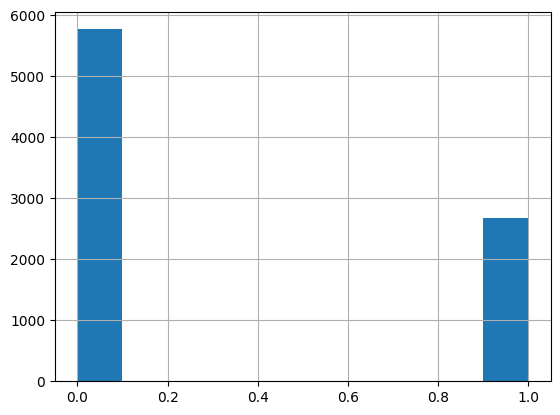

In [48]:

y_true.hist()
y_true.value_counts()


In [17]:
# instance the model
model_logreg = LogisticRegression(solver='liblinear', random_state=42)

# train the model
model_logreg.fit(x_train, y_train)

# predict the test results
y_pred_logreg = model_logreg.predict(x_test)

In [19]:
# instance basic model
model_mlp1 = Sequential()
 
# add dense layers with relu activation
model_mlp1.add(Dense(100, activation='relu'))
model_mlp1.add(Dense(50, activation='relu'))
model_mlp1.add(Dense(10, activation='relu'))
 
# add a sigmoid layer for activation
model_mlp1.add(Dense(1, activation='sigmoid'))

# build the model
model_mlp1.build(input_shape=x_train.shape)
 
# model summary
model_mlp1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (6754, 100)               9700      
                                                                 
 dense_1 (Dense)             (6754, 50)                5050      
                                                                 
 dense_2 (Dense)             (6754, 10)                510       
                                                                 
 dense_3 (Dense)             (6754, 1)                 11        
                                                                 
Total params: 15271 (59.65 KB)
Trainable params: 15271 (59.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# model visualization
visualkeras.layered_view(model_mlp1)

In [21]:
# compile the model
model_mlp1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [22]:
# train the model
history1 = model_mlp1.fit(x_train, y_train, epochs=10, batch_size=1, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10


6754/6754 [==============================] - 8s 1ms/step - loss: 0.2392 - accuracy: 0.9052 - val_loss: 0.1998 - val_accuracy: 0.9201
Epoch 2/10
6754/6754 [==============================] - 7s 1ms/step - loss: 0.1901 - accuracy: 0.9258 - val_loss: 0.1932 - val_accuracy: 0.9230
Epoch 3/10
6754/6754 [==============================] - 9s 1ms/step - loss: 0.1791 - accuracy: 0.9316 - val_loss: 0.1881 - val_accuracy: 0.9242
Epoch 4/10
6754/6754 [==============================] - 9s 1ms/step - loss: 0.1701 - accuracy: 0.9340 - val_loss: 0.2070 - val_accuracy: 0.9218
Epoch 5/10
6754/6754 [==============================] - 7s 1ms/step - loss: 0.1617 - accuracy: 0.9389 - val_loss: 0.2079 - val_accuracy: 0.9201
Epoch 6/10
6754/6754 [==============================] - 7s 1ms/step - loss: 0.1511 - accuracy: 0.9386 - val_loss: 0.1927 - val_accuracy: 0.9254
Epoch 7/10
6754/6754 [==============================] - 7s 1ms/step - loss: 0.1450 - accuracy: 0.9424 - val_loss: 0.2279 - val_accurac

In [23]:
# retrieve and display predictions
y_pred_mlp1 = [0 if x < .5 else 1 for x in model_mlp1.predict(x_test)]
print("accuracy: " + str(metrics.accuracy_score(y_test, y_pred_mlp1)))
print("confusion matrix:\n " + str(metrics.confusion_matrix(y_test, y_pred_mlp1)))

53/53 [==============================] - 0s 934us/step
accuracy: 0.9283599763173476
confusion matrix:
 [[1105   56]
 [  65  463]]


In [24]:
# instance basic model
model_mlp2 = Sequential()
 
# add dense layers with relu activation
model_mlp2.add(Dense(150, activation='relu'))
model_mlp2.add(Dense(120, activation='relu'))
model_mlp2.add(Dense(80, activation='relu'))
model_mlp2.add(Dense(50, activation='relu'))
model_mlp2.add(Dense(10, activation='relu'))

# add a dropout layer to reduce overfitting
model_mlp2.add(Dropout(0.3))
 
# add a sigmoid layer for activation
model_mlp2.add(Dense(1, activation='sigmoid'))

# build the model
model_mlp2.build(input_shape=x_train.shape)
 
# model summary
model_mlp2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (6754, 150)               14550     
                                                                 
 dense_5 (Dense)             (6754, 120)               18120     
                                                                 
 dense_6 (Dense)             (6754, 80)                9680      
                                                                 
 dense_7 (Dense)             (6754, 50)                4050      
                                                                 
 dense_8 (Dense)             (6754, 10)                510       
                                                                 
 dropout (Dropout)           (6754, 10)                0         
                                                                 
 dense_9 (Dense)             (6754, 1)                

In [25]:
# model visualization
visualkeras.layered_view(model_mlp2)

In [26]:
# let's customize our optimizer
optimizer = Adam(learning_rate=0.0001)

# compile the model
model_mlp2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

In [27]:
# train the model
history2 = model_mlp2.fit(x_train, y_train, epochs=15, batch_size=1, verbose=1, validation_data=(x_test, y_test))

Epoch 1/15
6754/6754 [==============================] - 9s 1ms/step - loss: 0.3009 - accuracy: 0.8784 - val_loss: 0.2070 - val_accuracy: 0.9201
Epoch 2/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.2173 - accuracy: 0.9199 - val_loss: 0.2032 - val_accuracy: 0.9165
Epoch 3/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.1930 - accuracy: 0.9246 - val_loss: 0.1937 - val_accuracy: 0.9130
Epoch 4/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.1839 - accuracy: 0.9316 - val_loss: 0.1920 - val_accuracy: 0.9159
Epoch 5/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.1698 - accuracy: 0.9369 - val_loss: 0.1931 - val_accuracy: 0.9213
Epoch 6/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.1598 - accuracy: 0.9405 - val_loss: 0.1904 - val_accuracy: 0.9236
Epoch 7/15
6754/6754 [==============================] - 8s 1ms/step - loss: 0.1494 - accuracy: 0.9467 - val_loss: 0.1951 - val_accuracy:

In [28]:
# retrieve and display predictions
y_pred_mlp2 = [0 if x < .5 else 1 for x in model_mlp2.predict(x_test)]
print("accuracy: " + str(metrics.accuracy_score(y_test, y_pred_mlp2)))
print("confusion matrix:\n " + str(metrics.confusion_matrix(y_test, y_pred_mlp2)))

53/53 [==============================] - 0s 966us/step
accuracy: 0.9236234458259325
confusion matrix:
 [[1087   74]
 [  55  473]]


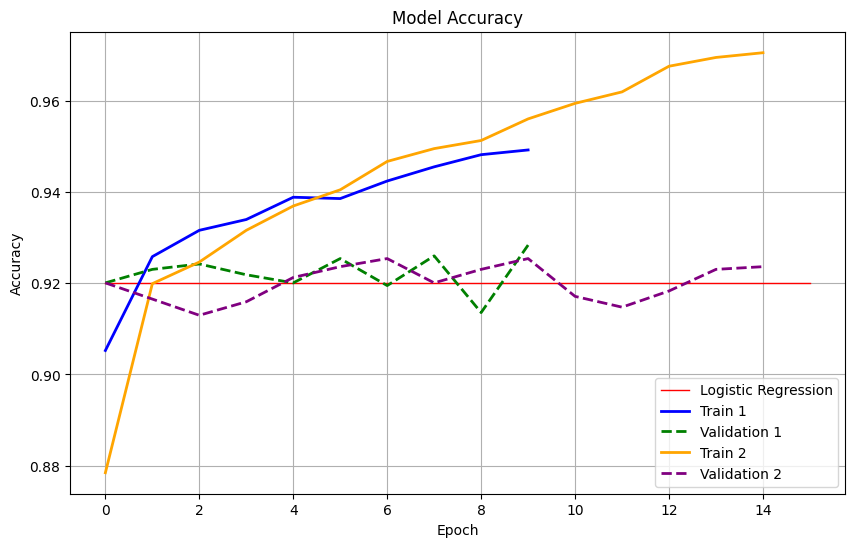

In [47]:

logreg_acc = metrics.accuracy_score(y_test, y_pred_logreg)


plt.pyplot.figure(figsize=(10, 6))
plt.pyplot.plot([0, 15], [logreg_acc, logreg_acc], linestyle='-', linewidth=1, color='red', label='Logistic Regression')
plt.pyplot.plot(history1.history['accuracy'], linestyle='-', linewidth=2, color='blue', label='Train 1')
plt.pyplot.plot(history1.history['val_accuracy'], linestyle='--', linewidth=2, color='green', label='Validation 1')
plt.pyplot.plot(history2.history['accuracy'], linestyle='-', linewidth=2, color='orange', label='Train 2')
plt.pyplot.plot(history2.history['val_accuracy'], linestyle='--', linewidth=2, color='purple', label='Validation 2')
plt.pyplot.title('Model Accuracy')
plt.pyplot.ylabel('Accuracy')
plt.pyplot.xlabel('Epoch')
plt.pyplot.legend(loc='lower right')
plt.pyplot.grid(True)
plt.pyplot.show()